In [17]:
import pathlib
import os
import json
import datetime

import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import google.generativeai as genai

from time import sleep
from google.generativeai import caching

In [18]:
CACHE_DIR = pathlib.Path(os.getcwd()) / "gemini_cache.txt"

PAYMENTS_MAIN_NEW_PATH = pathlib.Path(os.getcwd()) / ".." / "data" / "processed" / "payments_main.tsv"
PAYMENTS_MAIN_CATEGORIZED_PATH = pathlib.Path(os.getcwd()) / ".." / "data" / "processed" / "payments_categorized.tsv"

In [19]:
GOOGLE_API_KEY = os.environ.get('GOOGLE_API_KEY')
if GOOGLE_API_KEY is None:
    GOOGLE_API_KEY = input('Enter your Google API key: \n')
genai.configure(api_key=GOOGLE_API_KEY)

In [20]:
with open('gemini_response_schema.json' , 'r') as f:
    response_schema = json.load(f)
response_schema

{'type': 'object',
 'required': ['index', 'category'],
 'properties': {'index': {'type': 'integer'},
  'category': {'type': 'string',
   'format': 'enum',
   'enum': ['SERVICE',
    'NON_FOOD_GOODS',
    'LOAN',
    'NOT_CLASSIFIED',
    'LEASING',
    'FOOD_GOODS',
    'BANK_SERVICE',
    'TAX',
    'REAL_ESTATE']}}}

In [21]:
generation_config  = {
    "temperature": 1,
    "top_p": 0.95,
    "top_k": 40,
    "max_output_tokens": 8192,
}

In [22]:
test_system_prompt = """
Ты являешься экспертом по классификации платежей. Перед тобой набор данных, где каждая строка представляет один платеж. Твоя задача - определить наиболее вероятную категорию или категории каждого платежа из следующего списка:
* **BANK_SERVICE:** Банковские услуги, комиссии банка, кредиты, платежи за счёт банка, кредиты на покупку имущества, предоставление кредита
* **FOOD_GOODS:** Продукты питания, оплата еды
* **NON_FOOD_GOODS:** Непродовольственные товары, химикаты, косметика, одежда, бытовые товары
* **LEASING:** Лизинговые платежи, договоры лизинга, акты приема-передачи
* **LOAN:** Платежи по кредитам, процентные займы, договоры займа
* **REAL_ESTATE:** Операции с недвижимостью, инвестиции в недвижимость, аренда недвижимости, паевые взносы, покупка недвижимости, оплата аренды, жилое помещение
* **SERVICE:** Услуги (консалтинг, ремонт, транспорт и т.д.), оплата коммунальных услуг, лечение по договору,
* **TAX:** Налоги, сборы, штрафы, пошлины
* **NOT_CLASSIFIED:** Переводы на собственный счёт, оплата за сброс загрязняющих веществ, оборотные средства или если платёж не похож на любую другую категорию или имеет с ними слишком мало общего

Данные будут представлены в виде строк, где поля разделены табуляцией. Первое поле - сумма (любой формат), второе - описание платежа.

Учти, что при выборе категории ты должен опираться на ключевые слова, относящиеся к категориям. Ключевые слова могут быть сокращены или написаны с ошибкой.

ТЫ ДОЛДЖЕН ДАТЬ КАТЕГОРИЮ КАЖДОЙ СТРОКЕ. НЕ НАРУШАЙ JSON ФОРМАТ.
"""

In [35]:
document = genai.upload_file(CACHE_DIR)

In [36]:
cache = caching.CachedContent.create(
    model='models/gemini-1.5-flash-002',
    display_name='Payment classification example',
    system_instruction=test_system_prompt,
    contents=[document],
    ttl=datetime.timedelta(hours=1),
)

In [37]:
model = genai.GenerativeModel.from_cached_content(cached_content=cache)

In [26]:
payments = pd.read_csv(PAYMENTS_MAIN_NEW_PATH, sep='\t')
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         25000 non-null  object
 1   Amount       25000 non-null  object
 2   Description  25000 non-null  object
dtypes: object(3)
memory usage: 586.1+ KB


In [27]:
chunk_size = 50

chunk_step = round(len(payments)/chunk_size)
chunk_step

500

In [28]:
payments_chunks_raw = {str(i): {} for i in range(0, chunk_step)}
payments_chunks_processed = {str(i): {} for i in range(0, chunk_step)}

In [29]:
for i in range(len(payments_chunks_raw)):
    for j in range(chunk_size):
        row = payments.iloc[i*chunk_size + j]
        payment = row['Amount'].strip() + '\t' + row['Description'].strip()
        
        payments_chunks_raw[str(i)][str(j)] = payment

In [30]:
def contents_from_chunk(chunk):
    contents = str()
    for i in range(chunk_size):
        contents += chunk[str(i)].strip() + '\n'
    return contents.strip()

In [31]:
def validate_json(json_str):
    category_enum = [
        "SERVICE", "NON_FOOD_GOODS", "LOAN",
        "NOT_CLASSIFIED", "LEASING", "FOOD_GOODS",
        "BANK_SERVICE", "TAX", "REAL_ESTATE"
    ]
    
    try:
        data = json.loads(json_str)
        
        if not isinstance(data, list):
            return "Not a list"
        
        for item in data:
            if not isinstance(item, dict) or item['category'] not in category_enum:
                return f"Not a dictionary or index {item['index']} not in enum"
    
    except json.JSONDecodeError:
        return "Not a valid JSON string"
    
    return True

In [ ]:
while payments_chunks_processed[str(chunk_step - 1)] == {}:
    sleep(5)
    for index_chunk in payments_chunks_raw:
        if payments_chunks_processed[index_chunk] == {}:
            response = model.generate_content(contents_from_chunk(payments_chunks_raw[index_chunk]))
            response_str = response.text.strip('```json\n').replace("'", '"')
            
            validate_json_result = validate_json(response_str)
            if validate_json_result is not True:
                print(
                    f"""\n\n
                    SOMETHING WENT WRONG!!!
                    index_chunk: {index_chunk}
                    response_str: {response_str}
                    caused by: {validate_json_result}
                    \n\n"""
                )
                break
            
            response_json = json.loads(response_str)
            
            payments_chunks_processed[index_chunk] = response_json
            
            print(f"Chunk {index_chunk} completed out of {chunk_step - 1} chunks")
            sleep(2)

Chunk 383 completed out of 499 chunks
Chunk 384 completed out of 499 chunks
Chunk 385 completed out of 499 chunks
Chunk 386 completed out of 499 chunks
Chunk 387 completed out of 499 chunks
Chunk 388 completed out of 499 chunks
Chunk 389 completed out of 499 chunks
Chunk 390 completed out of 499 chunks
Chunk 391 completed out of 499 chunks
Chunk 392 completed out of 499 chunks
Chunk 393 completed out of 499 chunks
Chunk 394 completed out of 499 chunks
Chunk 395 completed out of 499 chunks
Chunk 396 completed out of 499 chunks
Chunk 397 completed out of 499 chunks
Chunk 398 completed out of 499 chunks



                    SOMETHING WENT WRONG!!!
                    index_chunk: 399
                    response_str: [
  {"index": 0, "category": "BANK_SERVICE"},
  {"index": 1, "category": "TAX"},
  {"index": 2, "category": "SERVICE"},
  {"index": 3, "category": "FOOD_GOODS"},
  {"index": 4, "category": "FOOD_GOODS"},
  {"index": 5, "category": "NON_FOOD_GOODS"},
  {"index": 6, "category

In [ ]:
#if payments_chunks_processed[str(chunk_step - 1)] == {}:
#    with open('dump_2.json', 'r') as f:
#        payments_chunks_processed = json.load(f)
payments_chunks_processed

{'0': [{'index': 0, 'category': 'SERVICE'},
  {'index': 1, 'category': 'SERVICE'},
  {'index': 2, 'category': 'TAX'},
  {'index': 3, 'category': 'SERVICE'},
  {'index': 4, 'category': 'LOAN'},
  {'index': 5, 'category': 'FOOD_GOODS'},
  {'index': 6, 'category': 'BANK_SERVICE'},
  {'index': 7, 'category': 'TAX'},
  {'index': 8, 'category': 'SERVICE'},
  {'index': 9, 'category': 'LEASING'},
  {'index': 10, 'category': 'FOOD_GOODS'},
  {'index': 11, 'category': 'FOOD_GOODS'},
  {'index': 12, 'category': 'SERVICE'},
  {'index': 13, 'category': 'NOT_CLASSIFIED'},
  {'index': 14, 'category': 'FOOD_GOODS'},
  {'index': 15, 'category': 'SERVICE'},
  {'index': 16, 'category': 'NOT_CLASSIFIED'},
  {'index': 17, 'category': 'LEASING'},
  {'index': 18, 'category': 'NON_FOOD_GOODS'},
  {'index': 19, 'category': 'FOOD_GOODS'},
  {'index': 20, 'category': 'BANK_SERVICE'},
  {'index': 21, 'category': 'LOAN'},
  {'index': 22, 'category': 'NON_FOOD_GOODS'},
  {'index': 23, 'category': 'FOOD_GOODS'},
  {

In [39]:
def check_neighbours(chunks, chunk_step):
    count_identical = 0
    previous_chunk = chunks['0']
    for i in range(1, chunk_step):
        current_chunk = chunks[str(i)]
        if previous_chunk == current_chunk:
            count_identical += 1
        previous_chunk = current_chunk

In [40]:
print(check_neighbours(payments_chunks_processed, chunk_step))

None


In [45]:
payments_categorized = payments
payments_categorized['Category'] = None
payments_categorized

,Date,Amount,Description,Category
0,07.11.2024,40500.00,За тур.поездку по договору №001 от 27.01.2023г,None
1,07.11.2024,"32600,00",За оказание услуг по договору №53Б-02746 от 23...,None
2,07.11.2024,4710-00,Оплата штрафа,None
3,07.11.2024,30900-00,Лечение по договору №Д-00359/24 от 08.03.2025,None
4,07.11.2024,13200.00,Оплата основного долга за период с 16.12.2024г...,None
...,...,...,...,...
24995,07.11.2024,"3300000,00",Оплата по договору №Е01905 от 25.02.2023. сырь...,None
24996,07.11.2024,"2270,00",гос.услуга,None
24997,07.11.2024,1750000.00,Предоставление кредита по договору №Д-00803/03...,None
24998,07.11.2024,3560.00,Оплата гос. пошлины,None


In [46]:
chunk_size

50

In [47]:
chunk_step

500

In [48]:
payments_categories = [None for _ in range(len(payments))]
len(payments_categories)

25000

In [49]:
for key, value in payments_chunks_processed.items():
    for item in value:
        if item['index'] < chunk_size:
            payments_categories[int(key)*chunk_size + item['index']] = item['category']

In [51]:
len(payments_categories) - payments_categories.count(None)

23433

In [52]:
payments_categorized['Category'] = payments_categories
payments_categorized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         25000 non-null  object
 1   Amount       25000 non-null  object
 2   Description  25000 non-null  object
 3   Category     23433 non-null  object
dtypes: object(4)
memory usage: 781.4+ KB


In [53]:
payments_categorized.dropna(inplace=True)

In [54]:
payments_categorized.reset_index(drop=True, inplace=True)

In [55]:
payments_categorized

,Date,Amount,Description,Category
0,07.11.2024,40500.00,За тур.поездку по договору №001 от 27.01.2023г,SERVICE
1,07.11.2024,"32600,00",За оказание услуг по договору №53Б-02746 от 23...,SERVICE
2,07.11.2024,4710-00,Оплата штрафа,TAX
3,07.11.2024,30900-00,Лечение по договору №Д-00359/24 от 08.03.2025,SERVICE
4,07.11.2024,13200.00,Оплата основного долга за период с 16.12.2024г...,LOAN
...,...,...,...,...
23428,07.11.2024,"4650,00",государственная пошлина,NON_FOOD_GOODS
23429,07.11.2024,248000000-00,По предвариельному договору №Б03411/33 от 27.0...,TAX
23430,07.11.2024,"36400,00",За участие в конференции в г. Саранск по догов...,BANK_SERVICE
23431,07.11.2024,"520000,00",Оплата по договору №А02682 от 07 декабря 2026г...,TAX


In [56]:
value_counts = payments_categorized['Category'].value_counts()
value_counts

Category
FOOD_GOODS        4938
SERVICE           4916
NON_FOOD_GOODS    3746
TAX               2054
LOAN              1968
LEASING           1738
BANK_SERVICE      1528
REAL_ESTATE       1398
NOT_CLASSIFIED    1147
Name: count, dtype: int64

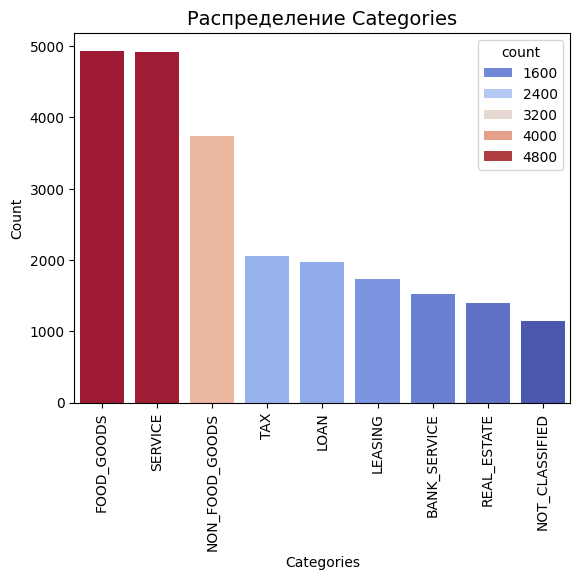

In [57]:
sns.barplot(
    x=value_counts.index,
    y=value_counts,
    palette='coolwarm',
    hue=value_counts
)
plt.xlabel('Categories', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Распределение Categories', fontsize=14)
plt.xticks(rotation=90)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.show()

In [58]:
payments_categorized.to_csv(PAYMENTS_MAIN_CATEGORIZED_PATH, sep='\t', index=False)